# Text Classification
* In this tutorial, we'll see a real-world example of text classification. We will train a ML model capable of predicting whether a given tweet is disaster-related or non-disaster. This is a classic example of sentimental analysis where tweet's sentiments towards a particular entity are classified into different categories.

# Dataset 
* The tweets have been pulled from Twitter and manual tagging has been done
* The id has been given seq # to avoid any privacy concerns
* Columns:
  * id
  * keyword
  * location
  * text
  * target

# Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Model building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Bag of Words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Word embedding
import gensim
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Step 2: Load data & EDA

In [2]:
df_train= pd.read_csv('train.csv', encoding="ISO-8859-1")
df_test=pd.read_csv('test.csv', encoding="ISO-8859-1")

# 2.1 Class distribution

0    4342
1    3271
Name: target, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


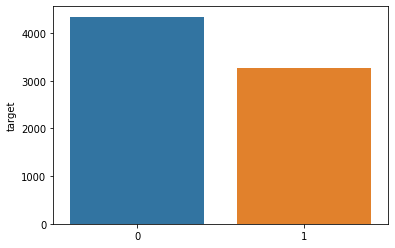

In [3]:
x=df_train['target'].value_counts()
print(x)
sns.barplot(x.index,x)

# 2.2 Missing values

In [4]:
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

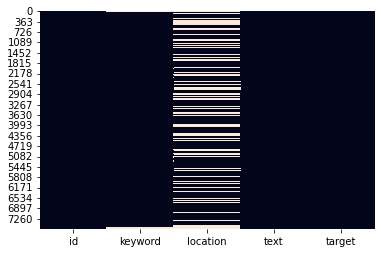

In [5]:
sns.heatmap(df_train.isnull(),cbar=False)

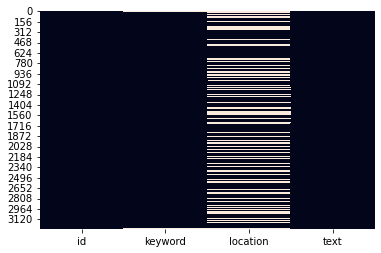

In [6]:
sns.heatmap(df_test.isnull(),cbar=False)

# 2.3 Number of words in a tweet

In [7]:
# WORD-COUNT
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
print(df_train[df_train['target']==1]['word_count'].mean()) # Positive tweets
print(df_train[df_train['target']==0]['word_count'].mean()) # Negative tweets

15.167532864567411
14.704744357438969


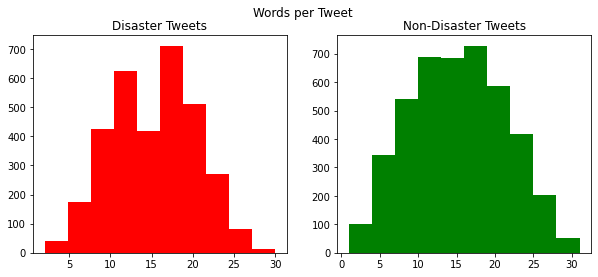

In [8]:
# PLOTTING WORD-COUNT
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['target']==1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Disaster Tweets')
train_words=df_train[df_train['target']==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Non-Disaster Tweets')
fig.suptitle('Words per Tweet')
plt.show()

# 2.4 Number of characters in a tweet

In [9]:
# char_count
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
# mention_count
df_train['mention_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

In [10]:
# char_count
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))
# mention_count
df_test['mention_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

# Step 3: Text Preprocessing
* Simple text cleaning processes:
  * Removing punctuations, special characters, URLs & hashtags
  * Removing leading, trailing & extra white spaces/tabs
  * Typos, slangs are corrected, abbreviations are written in their long forms

In [24]:
nltk.download('stopwords')

STOPWORDS = set(stopwords.words('english'))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df_test['text'] = df_test['text'].apply(lambda text: cleaning_stopwords(text))

df_train['text'] = df_train['text'].apply(lambda text: cleaning_stopwords(text))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)
df_train['text']= df_train['text'].apply(lambda x: cleaning_URLs(x))

df_test['text']= df_test['text'].apply(lambda x: cleaning_URLs(x))

In [26]:
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
df_train['text']= df_train['text'].apply(lambda x: cleaning_punctuations(x))

df_test['text']= df_test['text'].apply(lambda x: cleaning_punctuations(x))

In [27]:
def cleaning_numbers(data):
    return re.sub('[0-9]+','', data)
df_train['text']= df_train['text'].apply(lambda x: cleaning_numbers(x))

df_test['text']= df_test['text'].apply(lambda x: cleaning_numbers(x))

In [28]:
df_train.head()

,id,keyword,location,text,target,word_count,char_count,mention_count,clean_text,clean_text_tok
0,1,NaN,NaN,Our Deeds Reason earthquake May ALLAH Forgive us,1,13,69,0,deed reason earthquake may allah forgive u,"[deed, reason, earthquake, may, allah, forgive..."
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1,7,38,0,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked shelter place notified off...,1,22,133,0,resident ask shelter place notify officer evac...,"[resident, ask, shelter, place, notify, office..."
3,6,NaN,NaN,people receive wildfires evacuation orders Ca...,1,8,65,0,people receive wildfire evacuation order calif...,"[people, receive, wildfire, evacuation, order,..."
4,7,NaN,NaN,Just got sent photo Ruby Alaska smoke wildfire...,1,16,88,0,get sent photo ruby alaska smoke wildfires pou...,"[get, sent, photo, ruby, alaska, smoke, wildfi..."


In [29]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
df_train['text'] = df_train['text'].apply(tokenizer.tokenize)

df_test['text'] = df_test['text'].apply(tokenizer.tokenize)

In [30]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    data = [st.stem(word) for word in data]
    return data
df_train['text']= df_train['text'].apply(lambda x: stemming_on_text(x))

df_test['text']= df_test['text'].apply(lambda x: stemming_on_text(x))

In [31]:
# Convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text = text.strip()  
    text = re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# STOPWORD REMOVAL
def stopword(string):
    a = [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

# LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a = [wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

# Step 4: Extracting vectors from text (Vectorization)
* Count vectors
* Term Frequency-Inverse Document Frequencies (TF-IDF)

In [33]:
# Split training dataset into train & test
X_train, X_test, y_train, y_test = train_test_split(df_train["clean_text"],df_train["target"],test_size=0.2,shuffle=True)

In [34]:
# Word2Vec
# Word2Vec runs on tokenized sentences
X_train_tok= [nltk.word_tokenize(i) for i in df_train]  
X_test_tok= [nltk.word_tokenize(i) for i in df_test]

In [35]:
# Vectorization using Bag-of-Words (with TF-IDF) 

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)
# Build Word2Vec model
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))
    def fit(self, X, y):
        return self
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
df_train['clean_text_tok']=[nltk.word_tokenize(i) for i in df_train['clean_text']]
model = Word2Vec(df_train['clean_text_tok'],min_count=1)
w2v = dict(zip(model.wv.index2word, model.wv.syn0))  
modelw = MeanEmbeddingVectorizer(w2v)
# Convert text to numerical data using Word2Vec
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_test_tok)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


# Step 5. Running ML algorithms
* Logistic Regression
* Naive Bayes
* Random Forest

In [36]:
# Fit classification model using Logistic Regression (TF-IDF)
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  
# Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.80      0.81      0.80       865
           1       0.74      0.73      0.74       658

    accuracy                           0.78      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523

Confusion Matrix: [[698 167]
 [175 483]]
AUC: 0.8497390937681185


In [37]:
# Fit classification model using Naive Bayes (TF-IDF)
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  
# Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.77      0.91      0.83       865
           1       0.84      0.64      0.73       658

    accuracy                           0.79      1523
   macro avg       0.81      0.78      0.78      1523
weighted avg       0.80      0.79      0.79      1523

Confusion Matrix: [[787  78]
 [236 422]]
AUC: 0.8535463921148339


In [19]:
# Fit classification model using Random Forest (TF-IDF)
from sklearn.ensemble import RandomForestClassifier
rf_tfidf = RandomForestClassifier(n_estimators=1000, random_state=0)
rf_tfidf.fit(X_train_vectors_tfidf, y_train)

# Predict y value for test dataset
y_predict = rf_tfidf.predict(X_test_vectors_tfidf)
y_prob = rf_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.77      0.92      0.84       865
           1       0.85      0.65      0.74       658

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.79      1523
weighted avg       0.81      0.80      0.80      1523

Confusion Matrix: [[792  73]
 [231 427]]
AUC: 0.869841172233252


# SVM
* https://scikit-learn.org/stable/modules/svm.html

# Stochastic Gradient Descent
* https://scikit-learn.org/stable/modules/sgd.html

# GridSearch
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearch#sklearn.model_selection.GridSearchCV

# Neural Network Models
* https://scikit-learn.org/stable/modules/neural_networks_supervised.html

In [20]:
# Preprocess the new dataset
df_test['clean_text'] = df_test['text'].apply(lambda x: finalpreprocess(x)) 
X_test=df_test['clean_text'] 

# Convert words to numerical data using tf-idf
X_vector=tfidf_vectorizer.transform(X_test)

# Use the best model to predict 'target' value for the new dataset 
y_predict = lr_tfidf.predict(X_vector)      
y_prob = lr_tfidf.predict_proba(X_vector)[:,1]
df_test['predict_prob']= y_prob
df_test['target']= y_predict
final=df_test[['clean_text','target']].reset_index(drop=True)
print(final.head())

                                          clean_text  target
0                          happen terrible car crash       1
1  heard earthquake different city stay safe ever...       1
2  forest fire spot pond geese flee across street...       1
3                  apocalypse light spokane wildfire       1
4                 typhoon soudelor kill china taiwan       1


# Step 6: Save and Load the Model

In [22]:
# Save the model as a pickle object in Python
import pickle
with open('text_classifier', 'wb') as picklefile:
    pickle.dump(rf_tfidf,picklefile)

In [23]:
# Load the model
with open('text_classifier', 'rb') as training_model:
    model = pickle.load(training_model)